In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from wordcloud import WordCloud, STOPWORDS
from twython import Twython
import keys #twitter keys: APP_KEY, APP_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET

In [2]:
%load_ext watermark
%watermark -d -v -m -p pandas,scipy,matplotlib,twython

2016-12-24 

CPython 3.5.1
IPython 4.2.0

pandas 0.18.1
scipy 0.17.1
matplotlib 1.5.1
twython 3.4.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [3]:
# twython auth
twitter = Twython(keys.APP_KEY, keys.APP_SECRET,keys.OAUTH_TOKEN, keys.OAUTH_TOKEN_SECRET)

In [ ]:
#get more than 200 tweets: http://www.craigaddyman.com/mining-all-tweets-with-python/

In [4]:
# init empty lists to save tweets and metadata
user_ids, user_names, texts , creation, retweets ,favorites, lenguage, retweet, retweet_from, in_reply = ([] for i in range(10))
# get following IDs and NAMES (can get more info of users if needed!)
following_ids = [] # to save ids
following_names= {} # dictinary key:user_id, value: user_name
following = twitter.get_friends_list()
for u in following["users"]:
    following_ids.append(u['id'])
    following_names[u['id']]=u['name']

# get 200 tweets and metadata from each friend (can get more metadata if needed!)
for user_id in following_ids:
    tweets200 = twitter.get_user_timeline(user_id=user_id,count=200)
    for t in tweets200:
        user_ids.append(user_id)
        user_names.append(following_names[user_id])
        texts.append(t["text"])
        creation.append(t["created_at"])
        retweets.append(t["retweet_count"])
        favorites.append(t["favorite_count"])
        lenguage.append(t["lang"])
        in_reply.append(t['in_reply_to_screen_name'])
        retweet.append(('retweeted_status') in t)
        if ('retweeted_status') in t:
            retweet_from.append(t['retweeted_status']['user']['name'])
        else:
            retweet_from.append("N/A")

In [5]:
# create final DataFrame
mytweets = pd.DataFrame({'user_id':user_ids,'user_name':user_names, 'text':texts ,'retweet': retweet, 'creation':creation ,
              'retweets':retweets , 'favorites':favorites , 'lenguage':lenguage,'retweet_from': retweet_from,
              'in_reply':in_reply})
mytweets["in_reply"] = mytweets["in_reply"].map(lambda x: "None" if x is None else x) # fix in_replay column None type to "None"

In [6]:
# checks
print("size:", mytweets.shape, "\n------------------------") #size
print(mytweets.isnull().sum()) #column names $missing values 
print("\nreplies and retweets at the same time:",end=" ")
print(mytweets[(mytweets["in_reply"]!="None") & (mytweets["retweet"]==True)].size)

size: (3517, 10) 
------------------------
creation        0
favorites       0
in_reply        0
lenguage        0
retweet         0
retweet_from    0
retweets        0
text            0
user_id         0
user_name       0
dtype: int64

replies and retweets at the same time: 0


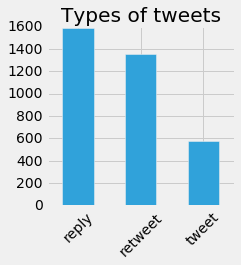

In [7]:
# Home many of all tweets are regular, tweeet, reply
def tweet_type(row):
    if row.retweet == True:
        return "retweet"
    elif row.in_reply == "None":
        return "reply"
    else:
        return "tweet"
# are there any replies and retweets?
a = mytweets.apply(tweet_type,1)
fig=plt.figure(figsize=(3,3))
a.value_counts().plot(kind='bar')
plt.title("Types of tweets")
plt.xticks(rotation=45)
plt.show()
del a

In [51]:
DEF mytweets.head()

,creation,favorites,in_reply,lenguage,retweet,retweet_from,retweets,text,user_id,user_name
0,Fri Dec 23 02:22:09 +0000 2016,0,None,en,True,Ted Ullyot,75,"RT @tullyot: From the @a16z Policy team, here'...",2529971,Chris Dixon
1,Wed Dec 21 17:38:21 +0000 2016,0,None,en,True,Max Roser,3438,RT @MaxCRoser: I have written a short history ...,2529971,Chris Dixon
2,Wed Dec 21 02:31:32 +0000 2016,277,None,en,False,N/A,209,"Zuckerberg: ""AI is both closer and farther off...",2529971,Chris Dixon
3,Tue Dec 13 18:38:25 +0000 2016,0,None,en,True,WIRED,142,RT @WIRED: Google is putting its weight behind...,2529971,Chris Dixon
4,Tue Dec 13 16:16:09 +0000 2016,0,None,en,True,Rok Strniša,54,RT @RokStrnisa: A massive day for @Improbablei...,2529971,Chris Dixon


In [35]:
def clean_tweets (tweets_string):
    # gets a string with all tweets and remove RT, links and ids (start with @)
    words_clean = " ".join([word for word in tweets_string.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
    return words_clean
    
# words of ALL TWEETS
words = clean_tweets(' '.join(mytweets['text']))
# words of ALL REGULAR TWEETS 
words_regular = clean_tweets(' '.join(mytweets[(mytweets["in_reply"]=="None") & (mytweets["retweet"]==False)].text))
# words of ONLY RETWEETS
words_rt = clean_tweets(' '.join(mytweets[mytweets["retweet"] == True].text))
# words of ONLY REPLIES
words_reply = clean_tweets(' '.join(mytweets[mytweets["in_reply"] != "None"].text))

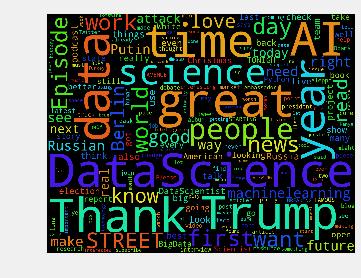

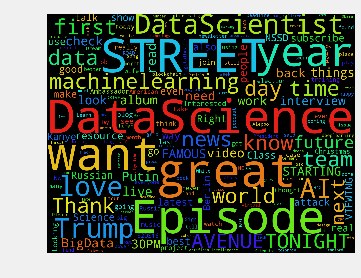

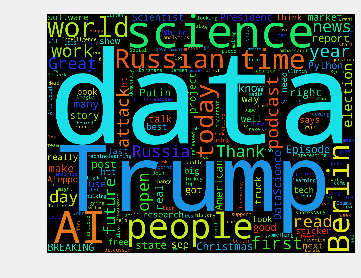

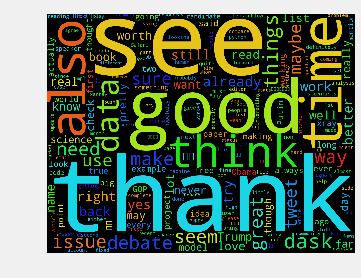

In [42]:
more_stopwords = {'new', 'amp', 'will', 'yet','via','now','one','thing','us','say','aslo','much'}
STOPWORDS = STOPWORDS.union(more_stopwords)

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400
                     ).generate(words)

plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig('./my_twitter_wordcloud_1.png', dpi=300)
plt.show()

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400
                     ).generate(words_regular)

plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig('./my_twitter_wordcloud_1.png', dpi=300)
plt.show()

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400
                     ).generate(words_rt)

plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig('./my_twitter_wordcloud_1.png', dpi=300)
plt.show()



wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400
                     ).generate(words_reply)

plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig('./my_twitter_wordcloud_1.png', dpi=300)
plt.show()

In [ ]:
#LDA  https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in doc_complete] 

In [ ]:
# https://www.quora.com/What-are-some-good-papers-about-topic-modeling-on-Tweets
# https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
# https://districtdatalabs.silvrback.com/modern-methods-for-sentiment-analysis
# https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/